### This notebook generates the SD-CAPE relationships for MCSs in the idealized RCE simulations. First import libraries and constants.

In [1]:
import numpy as np
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm
from zero_buoyancy_plume import zero_buoyancy_plume_alt

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# blue-to-red colormap
BR_color_cycle = ["navy", "blue", "lightskyblue", "tomato", "red", "darkred"]

## Loading RCE data

In [2]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
ssts = np.arange( 290, 315, 5 )
mean_RCE, p99_RCE, rad = read_RCE_files( path )

rad_RCE = np.concatenate( [r for r in rad], axis=0 )

# read in requisite values for ZBP CAPE calculations
T_RCE_all = RCE_concat( p99_RCE, 'TABS' )
qv_RCE_all = RCE_concat( p99_RCE, 'QV' )
P_RCE_all = RCE_concat( p99_RCE, 'p' )
sd_RCE = RCE_concat( p99_RCE, 'SD' )
p_rate_RCE = RCE_concat( p99_RCE, 'p_rate' )
altitudes = mean_RCE[0]['z'].to_numpy()

In [3]:
# filter values above for size and SD
loo = np.percentile( rad_RCE, 25 )
upp = np.percentile( rad_RCE, 75 )
upp2 = np.percentile( p_rate_RCE, 70 )
loo3 = np.percentile( sd_RCE, 50 )
upp3 = np.percentile( sd_RCE, 50 )

T_RCE_small = T_RCE_all[ rad_RCE <= loo ]
qv_RCE_small = qv_RCE_all[ rad_RCE <= loo ]
P_RCE_small = P_RCE_all[ rad_RCE <= loo ]

T_RCE_large = T_RCE_all[ rad_RCE >= upp ]
qv_RCE_large = qv_RCE_all[ rad_RCE >= upp ]
P_RCE_large = P_RCE_all[ rad_RCE >= upp ]

T_RCE = T_RCE_all[ p_rate_RCE >= upp2 ]
qv_RCE = qv_RCE_all[ p_rate_RCE >= upp2 ]
P_RCE = P_RCE_all[ p_rate_RCE >= upp2 ]

T_RCE_lowsd = T_RCE_all[ sd_RCE <= loo3 ]
qv_RCE_lowsd = qv_RCE_all[ sd_RCE <= loo3 ]
P_RCE_lowsd = P_RCE_all[ sd_RCE <= loo3 ]

T_RCE_highsd = T_RCE_all[ sd_RCE >= upp3 ]
qv_RCE_highsd = qv_RCE_all[ sd_RCE >= upp3 ]
P_RCE_highsd = P_RCE_all[ sd_RCE >= upp3 ]

In [4]:
# calculate ZBP buoyancies
epsilon = 0.2e-2 # 0.2 km-1
upper = 40
_, buoy_RCE = zero_buoyancy_plume_alt( np.nanmedian(T_RCE[:,:upper],0), np.nanmedian(qv_RCE[:,:upper],0)*1e-3,
                                    np.nanmedian(P_RCE[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )
_, buoy_RCE_all = zero_buoyancy_plume_alt( np.nanmedian(T_RCE_all[:,:upper],0), np.nanmedian(qv_RCE_all[:,:upper],0)*1e-3,
                                    np.nanmedian(P_RCE_all[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )
_, buoy_RCE_lowsd2 = zero_buoyancy_plume_alt( np.nanmedian(T_RCE_all[:,:upper],0), np.nanmedian(qv_RCE_lowsd[:,:upper],0)*1e-3,
                                    np.nanmedian(P_RCE_all[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )
_, buoy_RCE_highsd2 = zero_buoyancy_plume_alt( np.nanmedian(T_RCE_all[:,:upper],0), np.nanmedian(qv_RCE_highsd[:,:upper],0)*1e-3,
                                    np.nanmedian(P_RCE_all[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )
_, buoy_RCE_lowsd = zero_buoyancy_plume_alt( np.nanmedian(T_RCE_lowsd[:,:upper],0), np.nanmedian(qv_RCE_lowsd[:,:upper],0)*1e-3,
                                    np.nanmedian(P_RCE_lowsd[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )
_, buoy_RCE_highsd = zero_buoyancy_plume_alt( np.nanmedian(T_RCE_highsd[:,:upper],0), np.nanmedian(qv_RCE_highsd[:,:upper],0)*1e-3,
                                    np.nanmedian(P_RCE_highsd[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )

_, buoy_RCE_small = zero_buoyancy_plume_alt( np.nanmedian(T_RCE_small[:,:upper],0), np.nanmedian(qv_RCE_small[:,:upper],0)*1e-3,
                                     np.nanmedian(P_RCE_small[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )
#_, buoy_small3 = zero_buoyancy_plume_alt( np.nanmedian(temp_small,0), np.nanmedian(qv_small,0),
#                                     plev_ERAI, epsilon=1.375*epsilon )
_, buoy_RCE_large = zero_buoyancy_plume_alt( np.nanmedian(T_RCE_large[:,:upper],0), np.nanmedian(qv_RCE_large[:,:upper],0)*1e-3,
                                     np.nanmedian(P_RCE_large[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )
_, buoy_RCE_small2 = zero_buoyancy_plume_alt( np.nanmedian(T_RCE_small[:,:upper],0), np.nanmedian(qv_RCE_all[:,:upper],0)*1e-3,
                                     np.nanmedian(P_RCE_small[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )
_, buoy_RCE_large2 = zero_buoyancy_plume_alt( np.nanmedian(T_RCE_large[:,:upper],0), np.nanmedian(qv_RCE_all[:,:upper],0)*1e-3,
                                     np.nanmedian(P_RCE_large[:,:upper],0)*1e2, altitudes[:upper], epsilon=epsilon )

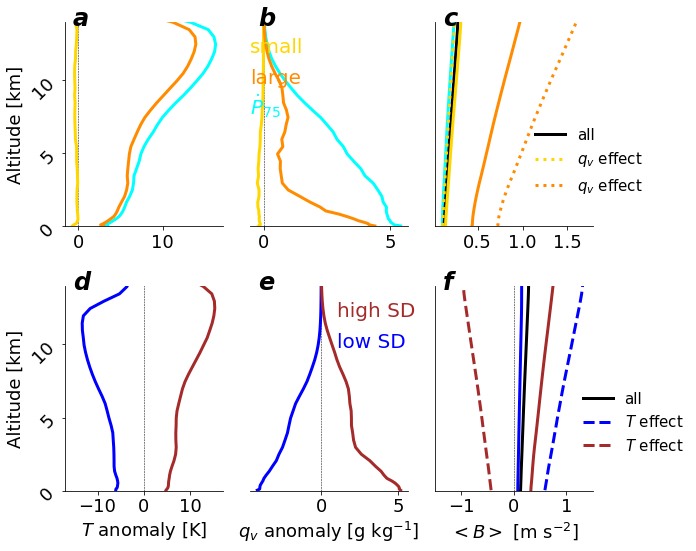

In [8]:
fig, ax = plt.subplots( 2, 3, figsize =(10, 8) )
let = [ 'a', 'b', 'c', 'd', 'e', 'f' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
alt_km = altitudes/1000. # factor of 1000 to convert m to km

for i, axis in enumerate(ax.flat): 
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.text( 0.05, 0.98, let[i], style='italic', weight='bold', fontsize=font_size+6, transform=axis.transAxes )
    axis.set_ylim( [0,14] )
    axis.tick_params( axis='y', labelrotation=45 )
    if i == 1 or i == 4:
        axis.spines['left'].set_visible( False )
        axis.set_yticklabels([])
        axis.set_yticks([])
    if i == 0:
        mt = np.nanmedian(T_RCE_all,axis=0)
        axis.plot( [0,0], [0,16], lw=0.5, ls='--', color='k' )
        axis.plot( np.nanmedian(T_RCE_small,axis=0) - mt, alt_km, color='gold', lw=3 )
        axis.plot( np.nanmedian(T_RCE,axis=0) - mt, alt_km, color='cyan', lw=3 )
        axis.plot( np.nanmedian(T_RCE_large,axis=0) - mt, alt_km, color='darkorange', lw=3 )
        #axis.set_xlim([-2.5, 2.5])
        axis.set_ylabel( 'Altitude [km]', fontsize=font_size )
    if i == 3:
        mt = np.nanmedian(T_RCE_all,axis=0)
        axis.plot( [0,0], [0,16], lw=0.5, ls='--', color='k' )
        axis.plot( np.nanmedian(T_RCE_lowsd,axis=0) - mt, alt_km, color='blue', lw=3 )
        axis.plot( np.nanmedian(T_RCE_highsd,axis=0) - mt, alt_km, color='brown', lw=3 )
        axis.set_xlabel( r'$T$ anomaly [K]', fontsize=font_size )
        axis.set_xlim([-17, 17])
        axis.set_ylabel( 'Altitude [km]', fontsize=font_size )
    if i == 1:
        mqv = np.nanmedian(qv_RCE_all,axis=0)
        axis.plot( [0,0], [0,16], lw=0.5, ls='--', color='k' )
        axis.plot( (np.nanmedian(qv_RCE,axis=0) - mqv), alt_km, color='cyan', lw=3 )
        axis.plot( (np.nanmedian(qv_RCE_small,axis=0) - mqv), alt_km, color='gold', lw=3 )
        axis.plot( (np.nanmedian(qv_RCE_large,axis=0) - mqv), alt_km, color='darkorange', lw=3 )
        #axis.set_xlim([-1.6, 1.6])
        axis.text( 0, 0.55, r'$\dot{P}_{75}$', color='cyan', fontsize=font_size+2, transform=axis.transAxes )
        axis.text( 0, 0.7, 'large', color='darkorange', fontsize=font_size+2, transform=axis.transAxes )
        axis.text( 0, 0.85, 'small', color='gold', fontsize=font_size+2, transform=axis.transAxes )
    if i == 4:
        axis.plot( [0,0], [0,16], lw=0.5, ls='--', color='k' )
        axis.plot( (np.nanmedian(qv_RCE_lowsd,axis=0) - mqv), alt_km, color='blue', lw=3 )
        axis.plot( (np.nanmedian(qv_RCE_highsd,axis=0) - mqv), alt_km, color='brown', lw=3 )
        axis.text( 0.55, 0.7, 'low SD', color='blue', fontsize=font_size+2, transform=axis.transAxes )
        axis.text( 0.55, 0.85, 'high SD', color='brown', fontsize=font_size+2, transform=axis.transAxes )
        axis.set_xlabel( r'$q_v$ anomaly [g kg$^{-1}$]', fontsize=font_size )
    if i == 2:
        axis.plot( buoy_RCE, alt_km[:upper], color='cyan', lw=3 )
        axis.plot( buoy_RCE_all, alt_km[:upper], color='black', lw=3, label='all'  )
        axis.plot( buoy_RCE_small, alt_km[:upper], color='gold', lw=3 )
        #axis.plot( buoy_RCE_small3, alt_km[:upper], color='goldenrod', lw=3, ls=':' )
        axis.plot( buoy_RCE_large, alt_km[:upper], color='darkorange', lw=3 )
        axis.plot( buoy_RCE_small2, alt_km[:upper], color='gold', lw=3, ls=':', label=r'$q_v$ effect' )
        axis.plot( buoy_RCE_large2, alt_km[:upper], color='darkorange', lw=3, ls=':', label=r'$q_v$ effect' )
        
        #axis.text( 0.6, 0.4, r'1.35$\epsilon$', color='goldenrod', fontsize=font_size+2, transform=axis.transAxes )
        axis.legend( frameon=False, fontsize=font_size-3, bbox_to_anchor=(0.55, 0.55) )
        #axis.set_xlim([0.1, 0.75])
        axis.set_yticks([])
        axis.set_yticklabels([])
    if i == 5:
        axis.plot( [0,0], [0,16], lw=0.5, ls='--', color='k' )
        axis.plot( buoy_RCE_all, alt_km[:upper], color='black', lw=3, label='all'  )
        axis.plot( buoy_RCE_lowsd, alt_km[:upper], color='blue', lw=3 )
        axis.plot( buoy_RCE_highsd, alt_km[:upper], color='brown', lw=3 )
        axis.plot( buoy_RCE_lowsd2, alt_km[:upper], color='blue', lw=3, ls='--', label=r'$T$ effect' )
        axis.plot( buoy_RCE_highsd2, alt_km[:upper], color='brown', lw=3, ls='--', label=r'$T$ effect' )
        axis.set_xlabel( r'$<B>$ [m s$^{-2}$]', fontsize=font_size )
        axis.legend( frameon=False, fontsize=font_size-3, bbox_to_anchor=(0.85, 0.55) )
        axis.set_xlim([-1.5,1.5])
        axis.set_yticks([])
        axis.set_yticklabels([]) 
        
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/qv-T-buoy-profiles-RCE.pdf', bbox_inches='tight' )
plt.show()